In [1]:
import math, random, numpy as np, matplotlib.pyplot as plt, torch
from tqdm import trange

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

def to_cpu_np(x): 
    return x.detach().to("cpu").numpy()

def rmse_torch(a, b, mask=None):
    """RMSE optionally on positions where mask==1."""
    if mask is None:
        return torch.sqrt(torch.mean((a - b)**2))
    # only masked (1) entries
    dif = (a - b)[mask.bool()]
    return torch.sqrt(torch.mean(dif**2))


Using device: cuda


In [2]:
# Data dims
N = 5000          # samples
D = 100           # observed dimensionality
K = 6             # latent dimensionality
SIGMA2 = 0.05     # true noise variance

set_seed(SEED)

# True PPCA params
W_true = torch.randn(D, K, device=device) * 0.7
mu_true = torch.randn(D, device=device) * 0.2

# Latents and data
z = torch.randn(N, K, device=device)
X_clean = mu_true + z @ W_true.T                         # [N,D]
X = X_clean + torch.sqrt(torch.tensor(SIGMA2, device=device)) * torch.randn_like(X_clean)

# Introduce 10% missing completely at random (MCAR)
missing_rate = 0.10
mask_obs = (torch.rand(N, D, device=device) > missing_rate).float()  # 1=observed, 0=missing
mask_mis = 1.0 - mask_obs

# Masked view (keep observed entries, zeros elsewhere)
X_obs = X * mask_obs

print(f"X: {tuple(X.shape)}, observed entries: {mask_obs.sum().item():.0f}/{N*D}")


X: (5000, 100), observed entries: 450339/500000


In [3]:
class PPCA_Missing_Torch:
    """
    PPCA with missing data (EM). Torch, CUDA-aware.

    E-step (per sample n):
      O = observed dims; Wn = W[O,:], mu_O = mu[O]
      M_n = I + (Wn^T Wn)/sigma^2
      b_n = Wn^T (x_O - mu_O)/sigma^2
      Ez_n  = solve(M_n, b_n)
      Ezz_n = sigma^2 * inv(M_n) + Ez_n Ez_n^T
      E[x|z]_n = mu + W Ez_n  (this also gives expected values for missing dims)

    M-step (using expected "complete" stats):
      mu = mean_n xhat_n
      W  = (sum_n (xhat_n - mu) Ez_n^T) @ (sum_n Ezz_n)^{-1}
      sigma^2 = (1/(N*D)) * [ sum_n ||xhat_n - mu||^2
                              - 2 Tr(W^T sum_n (xhat_n - mu) Ez_n^T)
                              + Tr(W^T W sum_n Ezz_n) ]
    """
    def __init__(self, k, max_iter=100, tol=1e-5, verbose=True, device=None):
        self.k = k
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
        self.W = None
        self.mu = None
        self.sigma2 = None
        self.history = []

    @torch.no_grad()
    def _init_params(self, X, mask_obs):
        N, D = X.shape
        # per-dimension mean using only observed entries
        cnt = torch.clamp(mask_obs.sum(dim=0), min=1.0)
        mu = (X.sum(dim=0) / cnt).clone()
        # fill missing with mu for a warm start
        X_filled = torch.where(mask_obs.bool(), X, mu.unsqueeze(0).expand_as(X))

        # PCA init via SVD on centered filled data
        Xc = X_filled - mu
        # safety economy SVD (could be heavy for huge N,D)
        U, S, Vh = torch.linalg.svd(Xc, full_matrices=False)
        V_k = Vh[:self.k, :].T                   # [D,k]
        # scale with sqrt eigenvalues ~ S^2/(N-1)
        eig = (S[:self.k]**2) / max(N-1,1)
        W = V_k * torch.sqrt(eig).unsqueeze(0)   # [D,k]
        # noise as avg leftover var
        if self.k < min(N,D):
            sigma2 = torch.mean((S[self.k:]**2)/max(N-1,1)).clamp(min=1e-6)
        else:
            sigma2 = torch.tensor(1e-6, device=self.device)

        self.mu = mu.to(self.device)
        self.W = W.to(self.device)
        self.sigma2 = sigma2.to(self.device)

    @torch.no_grad()
    def fit(self, X, mask_obs):
        X = X.to(self.device)
        mask_obs = mask_obs.to(self.device)
        N, D = X.shape

        self._init_params(X, mask_obs)

        I_k = torch.eye(self.k, device=self.device)
        prev_ll = -float("inf")

        for it in range(self.max_iter):
            # ----- E-step -----
            # accumulate sufficient statistics
            sum_xhat = torch.zeros(D, device=self.device)
            Sxz = torch.zeros(D, self.k, device=self.device)
            Szz = torch.zeros(self.k, self.k, device=self.device)
            sq_center_sum = 0.0

            for n in range(N):
                m = mask_obs[n].bool()
                x_o = X[n, m]                # observed part
                mu_o = self.mu[m]
                Wn = self.W[m, :]            # [|O|,k]

                # M_n = I + (Wn^T Wn)/sigma^2
                M = I_k + (Wn.T @ Wn) / self.sigma2
                # b_n = Wn^T (x_o - mu_o)/sigma^2
                b = (Wn.T @ (x_o - mu_o)) / self.sigma2
                Ez = torch.linalg.solve(M, b)                     # [k]
                Minv = torch.linalg.inv(M)
                Ezz = self.sigma2 * Minv + torch.outer(Ez, Ez)    # [k,k]

                # Expected full xhat = mu + W Ez
                xhat = self.mu + self.W @ Ez

                sum_xhat += xhat
                Sxz += torch.outer(xhat - self.mu, Ez)
                Szz += Ezz

                # accumulate squared centered norm for sigma2 update
                sq_center_sum += torch.sum((xhat - self.mu)**2).item()

            # ----- M-step -----
            mu_new = (sum_xhat / N).clone()
            # center Sxz by new mu (we used old mu to accumulate; correct centering):
            # Recompute Sxz_centered = sum (xhat - mu_new) Ez^T = Sxz - N*(mu_new - mu_old) Ez_sum^T
            # but we didn't store Ez_sum; simplest is to recompute small correction:
            # We'll just re-accumulate quick correction by relooping over N to avoid algebra bugs.
            # (N is moderate; K small)
            Ez_sum = torch.zeros(self.k, device=self.device)
            for n in range(N):
                m = mask_obs[n].bool()
                x_o = X[n, m]
                mu_o = self.mu[m]
                Wn = self.W[m, :]
                M = I_k + (Wn.T @ Wn) / self.sigma2
                b = (Wn.T @ (x_o - mu_o)) / self.sigma2
                Ez = torch.linalg.solve(M, b)
                Ez_sum += Ez
            Sxz_centered = Sxz - torch.outer(mu_new - self.mu, Ez_sum)

            W_new = torch.linalg.solve(Szz.T, Sxz_centered.T).T   # (Sxz_centered) @ (Szz^{-1})

            # sigma^2 update
            term1 = sq_center_sum
            term2 = 2.0 * torch.trace(W_new.T @ Sxz_centered)
            term3 = torch.trace((W_new.T @ W_new) @ Szz)
            sigma2_new = (term1 - term2 + term3) / (N * D)
            sigma2_new = torch.clamp(sigma2_new, min=1e-8)

            # crude data log-likelihood proxy (optional):
            ll = -float(sigma2_new.item())  # just a monotone proxy to check progress

            self.mu, self.W, self.sigma2 = mu_new, W_new, sigma2_new

            self.history.append({"iter":it, "sigma2":float(self.sigma2.item())})
            if self.verbose and it % 5 == 0:
                print(f"[EM {it:03d}] sigma2={self.sigma2.item():.6f}")

            if abs(ll - prev_ll) < self.tol:
                break
            prev_ll = ll

        return self

    @torch.no_grad()
    def transform(self, X, mask_obs):
        """Return Ez for each sample using only observed entries."""
        X = X.to(self.device)
        mask_obs = mask_obs.to(self.device)
        N, D = X.shape
        I_k = torch.eye(self.k, device=self.device)
        Ez_all = torch.zeros(N, self.k, device=self.device)

        for n in range(N):
            m = mask_obs[n].bool()
            x_o = X[n, m]
            mu_o = self.mu[m]
            Wn = self.W[m, :]
            M = I_k + (Wn.T @ Wn) / self.sigma2
            b = (Wn.T @ (x_o - mu_o)) / self.sigma2
            Ez = torch.linalg.solve(M, b)
            Ez_all[n] = Ez
        return Ez_all

    @torch.no_grad()
    def impute(self, X, mask_obs):
        """Return E[x|obs] = mu + W Ez for each sample."""
        Ez = self.transform(X, mask_obs)
        Xhat = self.mu + Ez @ self.W.T
        return Xhat


In [4]:
ppca = PPCA_Missing_Torch(k=K, max_iter=60, tol=1e-5, verbose=True, device=device)
ppca.fit(X_obs, mask_obs)

# Impute: \hat{x} = mu + W E[z|obs]
X_imp = ppca.impute(X_obs, mask_obs)

# Error only on the originally missing entries
rmse_missing = rmse_torch(X_imp, X, mask=mask_mis).item()
mae_missing  = torch.mean(torch.abs((X_imp - X)[mask_mis.bool()])).item()

print(f"Imputation RMSE on missing entries: {rmse_missing:.6f}")
print(f"Imputation MAE  on missing entries: {mae_missing:.6f}")
print(f"Learned sigma^2: {ppca.sigma2.item():.6f}")


[EM 000] sigma2=0.006023
Imputation RMSE on missing entries: 0.232735
Imputation MAE  on missing entries: 0.185931
Learned sigma^2: 0.000000


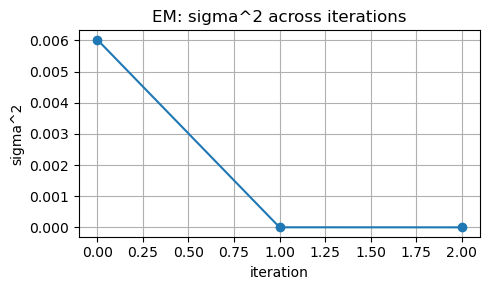

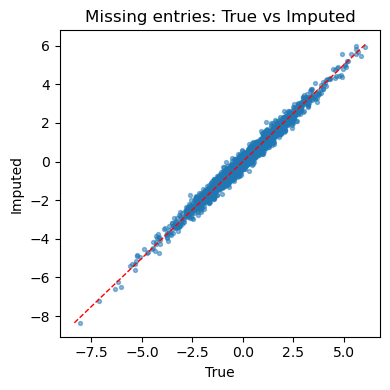

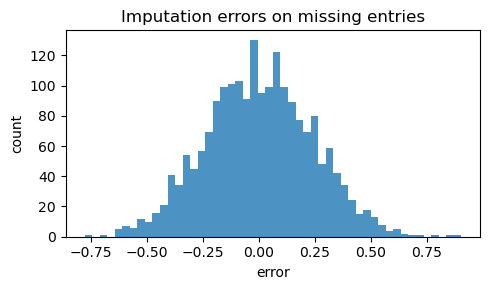

In [5]:
# 1) Convergence trace
sigmas = [h["sigma2"] for h in ppca.history]
plt.figure(figsize=(5,3))
plt.plot(sigmas, marker="o"); plt.grid(True)
plt.title("EM: sigma^2 across iterations")
plt.xlabel("iteration"); plt.ylabel("sigma^2")
plt.tight_layout(); plt.show()

# 2) True vs Imputed (on missing only) — subsample for scatter
idx_flat = mask_mis.view(-1).nonzero(as_tuple=False).view(-1)
sub = idx_flat[torch.randperm(len(idx_flat))[:2000]]
true_vals = X.view(-1)[sub].detach().cpu().numpy()
imp_vals  = X_imp.view(-1)[sub].detach().cpu().numpy()

plt.figure(figsize=(4,4))
plt.scatter(true_vals, imp_vals, s=8, alpha=0.5)
mn = min(true_vals.min(), imp_vals.min()); mx = max(true_vals.max(), imp_vals.max())
plt.plot([mn, mx],[mn, mx], 'r--', linewidth=1)
plt.xlabel("True"); plt.ylabel("Imputed")
plt.title("Missing entries: True vs Imputed")
plt.tight_layout(); plt.show()

# 3) Error histogram
errs = (imp_vals - true_vals)
plt.figure(figsize=(5,3))
plt.hist(errs, bins=50, alpha=0.8)
plt.title("Imputation errors on missing entries")
plt.xlabel("error"); plt.ylabel("count")
plt.tight_layout(); plt.show()


In [6]:
# Baseline 1: Per-dimension observed-mean fill
cnt = torch.clamp(mask_obs.sum(dim=0), min=1.0)
mu_obs = (X_obs.sum(dim=0) / cnt)
X_meanfill = torch.where(mask_obs.bool(), X_obs, mu_obs)
rmse_mean = rmse_torch(X_meanfill, X, mask=mask_mis).item()

# Baseline 2: Zero fill (very naive)
X_zerofill = X_obs.clone()
rmse_zero = rmse_torch(X_zerofill, X, mask=mask_mis).item()

print(f"Baseline RMSEs on missing entries:")
print(f"  Zero fill : {rmse_zero:.6f}")
print(f"  Mean fill : {rmse_mean:.6f}")
print(f"  PPCA fill : {rmse_missing:.6f}")


Baseline RMSEs on missing entries:
  Zero fill : 1.731350
  Mean fill : 1.722997
  PPCA fill : 0.232735
